<a href="https://colab.research.google.com/github/amey-joshi/am/blob/master/p4/Image_Alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This tutorial presents an algorithm that aligns image with model data. Such a need arises quite frequently in image registration. In an image registration problem we are given two images, the model image $U$ and an sample image $V$ and we are asked to find a transformation that aligns $U$ along $V$. $U$ and $V$ could be acquired simultaneously using two different acquisition systems. For example, $U$ could be an MRI scan while $V$ could be a CT scan. Alternatively, $U$ and $V$ could be images of the same object taken at different times. They could be MRI scans of the same portion of a patient taken a few days apart.

If a transformation $\tau$ is given then it is easy to apply it to an image $U$ and get the result $V$. The problem of finding $\tau$ given $U$ and $V$ is quite difficult. The number of functions mapping one image to another is very large and it is quite difficult to search for the best transformation. We now describe the problem in mathematical terms.

Let $x \in \mathbb{R}^2$ denote the coordinates of the image $U$ and $y \in \mathbb{R}^2$ denote the coordinates of image $V$. Thus, the data of the image $U$ is given by a function $u$ of $x$. Likewise that of $V$ is given y another function $v$ of $y$. Instead of calling the images $U$ and $V$ we can as well call them $u(x)$ and $v(y)$. 

One of the first tasks is to find a way to map $x$ to $y$. That is, we need to find a function $T$ such that $y = T(x)$. Next, there is a function $F$, called the imaging function that gives $V$ given $U$ and certain other exogenous parameters like lighting. Thus
$$\tag{1}
v(y) = F(u(x), q).
$$
However, the relationship between the two images is never deterministic. There is always a noise introduced in the process. Therefore, we must modify equation (1) to get
$$\tag{2}
v(y) = F(u(x), q) + \eta,
$$
where $\eta$ denotes the noise. Recall that $y = T(x)$ so that $x = T^{-1}(y)$. Therefore, an equivalent way of writing (1) is
$$\tag{3}
v(y) = F\left(u\left(T^{-1}(y)\right), q\right)  + \eta.
$$

Equation (3) tells us why image alignment is a difficult problem.

1. If we are dealing with rigid bodies then $T$ will in general be six dimensional. Three of them representing translation and three others the rotation. If the bodies are deformable, then the transformation can be potentially infinite dimensional.
2. It is almost impossible to know or control the exogenous parameters $q$.
3. As we remarked in the opening paragraph, there are a large number of functions mapping two given images. Finding the right one is a very difficult problem. Thus, even modeling $F$ is hard.

This tutorial takes a different take. Instead of trying to find out the best $T$ and $F$, it tries to find out the mutual information between the images $U$ and $V$. The algorithm can be summarized by the following equation. Given two images $U$ and $V$ whose data is expressed as $u(x)$ and $v(y)$, find 
$$\tag{4}
\hat{T} = \mathrm{arg\,max}_T I(u(x), v(T(x)).
$$
It means, find the transformation $T$ that maximizes the mutual information between $U$ and $V$. The algorithm goes by the name **em**pirical entropy **m**anipulation and **a**nalysis or its acronym **EMMA**.



# An alignment example

Let us refer to figure I of the [paper](https://dspace.mit.edu/bitstream/handle/1721.1/7065/AITR-1548.pdf?sequence=2&origin=publication_detail). 

The three dimensional models of the shape of the object are shown in figure 2. We want to find out using an algorithm which one of them is aligned with the video image of figure 1. This example clarifies what an image and a model are. An image is what is captured by a camera. A model is a mathematical representation of the object. The goal of this exercise is to align the model to an image.

Although humans can very quickly conclude that the left hand image in figure 2 is better aligned with the video image of figure 1, having computers infer the same is a very difficult task. The pixels are uncorrelated. Yet people are able to identify the alignment because the information content is the same. The question then is how to define information in mathematical terms.

This brings us to the idea of **consistency** of an imaging function like $F$ defined in the previous section. $F$ is consistent of similar normals to images $U$ and $V$ have similar intensities. Note that this definition does not mention the direction of lighting, the direction of viewing or the nature of the reflecting surface. Neither of these are used by the humans in making up their minds on whether two images are aligned. When a model and an image are aligned the imaging function relating the two will be consistent and that alone should suffice to build an algorithm for image registration. In the next section we will build a mathematical definition of consistency.

## A formal definition of consistency

The probability of an image $V$, described by the function $v$ given a model $U$, described by the function $u$  and a transformation $T$ is given by
$$\tag{1}
p(v|u, T) = \iint \prod_{x_a}p\left(\eta = v(T(x_a)) - F(u(x_a), q)\right)p(F)p(q)dFdq.
$$
The points $x_a$ are all the points of the model. Let us understand this equation in greater details. Select a point, say $x_1$ of the model. Then the probability that the image point corresponding to it is explained by equation (2) (or equation (3)) of the Introduction section is $p\left(\eta = v(T(x_a)) - F(u(x_a), q)\right)$ We multiply it by the probability that the imaging function takes the 'value' F and then by the probability that the exogenous factors are described by $q$. We then compute the marginal distribution by integrating over $F$ ad $q$. Lastly, we repeat this procedure for every point of the model.

It is quite clear that it is very difficult to work with equation (1). For,

- No one know the probability distributions of $q$ and $F$.
- Even if one assumes a distribution, performing the integration and the sum are not trivial tasks.

One can simplify equation (1) by *assuming* that the actual value of $p(v|u, T)$ is not drastically different from the **most probable value** of the integrand. That is, we approximate
$$\tag{2}
p(v|u, T)  = \max_{F, q}\prod_{x_a}p\left(\eta = v(T(x_a)) - F(u(x_a), q)\right)
$$

Equation (2) can be implemented as follows:

1. Assume a transformation $T$ and find $F, q$ that takes the model as close to the image as possible;
2. Use the $F, q$ estimated in the previous step and find $T$ that takes the model as close to the image as possible;
3. Repeat the above steps until the difference between the image and the model drops *below* a certain threshold.

If the algorithm converges, we will get a transformation $T$ that associates a point $x$ of the model to a point $T(x)$ of the image. The next step is to fit the points $u(x), v(T(x))$ with functions $F$ and $q$.

In proposing this algorithm the authors have also assumed that the tranformation $T$ is consistent. This brings us to a more rigorous definition of consistency.

**Definition** A transformation $T$ is consistent if $|u(x_1) - u(x_2)|$ is not too different from $|v(T(x_1)) - v(T(x_2))|$.

However, one of the problems with this approach is that the algorithm favours $T$ that is a constant.

To summarize, the definition (1) which is theoretically sound is practically intractable while the approximation (2) while being practical is prone to converge to a constant transformation.

# From likelihood to entropy

Given the difficulties in implementing equation (1) we abandon the search for an imaging function $F$ and focus on finding ways to 'predict' the image $V$ from the model $U$. The idea of predictability is closely related to that of **entropy**. A random variable with low entropy has a lesser uncertainty and more predictable than a random variable with higher entropy. The entropy of a random variable $X$ taking values $x$ is defined by
$$\tag{1}
h(x) = -\int p(x)\ln p(x) dx,
$$
where $p$ is the density of $X$. The **joint entropy** of random variables $X$ and $Y$ is given by
$$\tag{2}
h(x, y) = -\iint p(x, y) \ln p(x, y) dxdy
$$
<font color = "red">There is an error in equation (10) of the [paper](https://dspace.mit.edu/bitstream/handle/1721.1/7065/AITR-1548.pdf?sequence=2&origin=publication_detail). The variable $z$ should be replaced with $x$.</font>

However, entropy as guiding principle can be unreliable when the image $V$ is in general predictable. For it cannot differentiate between the conditions 

- $V$ is predictable if we know $U$ and
- $V$ is generally predictable.

For if the search stops at a $V$ which has low entropy then we might end up being with an image that is predictable but no way related to the model $U$. In order to bring the characteristics of $U$ in our search, we take recourse to the idea of **mutual information** between images. It is defined as 
$$\tag{3}
I(u(x), v(T(x))) = h(u(x)) + h(v(T(x))) - h(u(x), v(T(x))).
$$

If $U$ and $V$ were unrelated to each other, the joint distribution of $u$ and $v$ will be equal to the product of their marginal distributions. In this case, $h(u(x)) + h(v(T(x)))$ will be equal to $h(u(x), v(T(x)))$ and hence $I(u(x), v(T(x)))$ will be zero. As the dependence between $U$ and $V$ increases, as one becomes more predictable from the other, $I$ will start increasing. This is the idea used in the empirical entropy manipulation and analysis or EMMA algorithm. We introduce it in the next section.


# EMMA
We reiterate that the crux of EMMA is: given two images $U$ and $V$ whose data is expressed as $u(x)$ and $v(y)$, find 
$$\tag{1}
\hat{T} = \mathrm{arg\,max}_T I(u(x), v(T(x)).
$$
Here $x$ is a random variable over coordinates of the model. In the case of digital images, it is a random variable over allowed indices of the model.

Equation (1) in the section <a href>From likelihood to entropy</a> can as well be interpreted as
$$\tag{2}
h(x) = \text{E}(\ln p(x)).
$$
Expectations can be implemented by arithmetic means. Therefore, in order to find the entropy $h$ we need to estimate the density $p(x)$. We do so using the **Parzen window** method. Thus,
$$\tag{3}
p(x) = \frac{1}{N_A}\sum_{x_i \in A}G_\psi(x - x_j),
$$
where the set $A$ is a sample of model locations and the function $G_\psi$ is defined as
$$\tag{4}
G_\psi(x) = \frac{1}{(2\pi)^{n/2}|\psi|^{1/2}}\exp\left(-\frac{x^T\psi x}{2}\right),
$$
where $x \in \mathbb{R}^n$ and $\psi$ is the covariance matrix of the random vector $x$. Whatever be the dimension of $x$, $G_\psi$ is a real number. The entropy of a random variable $X$ can now be implemented as
$$\tag{5}
h(x) \approx -\frac{1}{N_B}\sum_{x_i \in B}\ln\left(\frac{1}{N_A}\sum_{x_j \in A}G_{\psi}(x_i - x_j)\right).
$$
The equation assures us that whatever be the nature of $X$, $h(x)$ is a number. Note the important point that it is permissible to use two different samples to estimate the density $G_\psi$ and the expectation in entropy's definition.

Let us assume that the random variable also depends on a parameter, say $t$. It can then be shown that
$$\tag{6}
\frac{dh}{dt} \approx \frac{1}{N_B}\sum_{x_i \in B}\sum_{x_j \in B}W_x(x_i, x_j)(x_i - x_j)^T\psi^{-1}\frac{d}{dt}(x_i - x_j),
$$
where
$$\tag{7}
W_x(x_i, x_j) = \frac{G_{\psi}(x_i - x_j)}{\sum_{x_k \in A}G_{\psi}(x_i - x_k)}.
$$
Clearly, $W_x(x_i, x_j)$ is a number. In fact $0 \le W_x(x_i, x_j) \le 1$. If $x \in \mathbb{R}^n$ then $\psi^{-1}$ is an $n \times n$ matrix and hence the product
$$
(x_i - x_j)^T\psi^{-1}\frac{d}{dt}(x_i - x_j)
$$
is a number. *We avoided using $T$ to denote an arbitrary parameter because we do not want to reuse the symbol for the image transformation*.

Recall the definition of mutual entropy in equation (3) in the section <a href>From likelihood to entropy</a>. It immediately follows that
$$\tag{8}
\frac{d}{dT}I(u(x), v(T(x))) = \frac{d}{dT}h(u(x)) + \frac{d}{dT}h(v(T(x))) - \frac{d}{dT}h(u(x), v(T(x))).
$$
The first term on the right hand side does not depend on $T$ and is therefore zero. Thus,
$$\tag{9}
\frac{d}{dT}I(u(x), v(T(x))) = \frac{d}{dT}h(v(T(x))) - \frac{d}{dT}h(u(x), v(T(x))).
$$
We can approximate the first term on the right hand side as
$$\tag{10}
\frac{d}{dT}h(v(T(x))) \approx \frac{1}{N_B}\sum_{v_i \in B}\sum_{v_j \in B}W_v(v_i, v_j)(v_i - v_j)^T\psi_v^{-1}\frac{d}{dt}(v_i - v_j),
$$
where $\psi_v^{-1}$ is the covariance matrix of $v$. If $v$ is a real valued random variable then $\psi_v^{-1}$ is just its variance.

In order to approximate the second term, we create a random variable $w = (x, y)^T$. Then $h(u(x), v(T(x))) = h(w)$ and hence
$$\tag{11}
\frac{d}{dT}h(w) \approx \frac{1}{N_B}\sum_{w_i \in B}\sum_{w_j \in B}W_w(w_i, w_j)(w_i - w_j)^T\psi_w^{-1}\frac{d}{dt}(w_i - w_j).
$$
Since $w = (x, y)$ even for gray-scale images for which $x, y \in \mathbb{R}$, $w \in \mathbb{R}^2$. Yet the term
$$
(w_i - w_j)^T\psi^{-1}\frac{d}{dt}(w_i - w_j)
$$
is a number.

The estimate of the derivative of mutual information with respect to $T$ is
$$\tag{12}
\widehat{\frac{dI}{dT}} = \frac{1}{N_B}\sum_{v_i \in B}\sum_{v_j \in B}W_v(v_i, v_j)(v_i - v_j)^T\psi_v^{-1}\frac{d}{dt}(v_i - v_j) - 
\frac{1}{N_B}\sum_{w_i \in B}\sum_{w_j \in B}W_w(w_i, w_j)(w_i - w_j)^T\psi_w^{-1}\frac{d}{dt}(w_i - w_j).
$$

**Important note:** 

This expression differs from the one mentioned in the [paper](https://dspace.mit.edu/bitstream/handle/1721.1/7065/AITR-1548.pdf?sequence=2&origin=publication_detail), namely
$$\tag{13}
\widehat{\frac{dI}{dT}} = \frac{1}{N_B}\sum_{x_i \in B}\sum_{x_j \in A}(v_i - v_j)^T\left[W_v(v_i, v_j)\psi_v^{-1} - W_{uv}(w_i, w_j)\psi_{vv}^{-1}\right]\frac{d}{dT}(v_i - v_j).
$$

We believe that this expression is erroneous because if $v \in \mathbb{R}^n$ then $w \in \mathbb{R}^{2n}$ and hence the product 
$$
(v_i - v_j)^T\psi_{vv}^{-1}\frac{d}{dT}(v_i - v_j)
$$
is not defined. For $(v_i - v_j)^T$ is a row vector is an $1 \times n$ matrix and $\psi_{vv}^{-1}$ is a $2n \times 2n$ matrix. 

We also consulted Paul Viola's [Ph.D. thesis](https://dspace.mit.edu/handle/1721.1/9918#files-area). But the equation mentioned in it (topmost equation on page 101) is
$$\tag{13}
\widehat{\frac{dI}{dT}} = \frac{1}{N_B}\sum_{x_i \in B}\sum_{x_j \in A}(v_i, v_j)^T\left[W_v(v_i, v_j)\psi_v^{-1} - W_{uv}(w_i, w_j)\psi_{vv}^{-1}\right]\frac{d}{dT}(v_i - v_j).
$$
In this case, the following terms cannot be evaluated because the matrices involved in their definition are incompatible.
$$
(v_i, v_j)^T W_v(v_i, v_j)\psi_v^{-1} \;\text{and}\; \psi_{vv}^{-1}\frac{d}{dT}(v_i - v_j)
$$
although the term $(v_i, v_j)^T\psi_{vv}^{-1}$ can be computed.

<font color = "blue">In this tutorial, we will use equation (12) as the definition of the derivative of mutual information with respect to $T$.</font>

Both, the [paper](https://dspace.mit.edu/bitstream/handle/1721.1/7065/AITR-1548.pdf?sequence=2&origin=publication_detail) and the [Ph.D. thesis](https://dspace.mit.edu/handle/1721.1/9918#files-area) define the derivative with respect to $T$ as
$$
\frac{dv(T(x_i))}{dT} = \nabla v \; x_i^T.
$$
If $v$ were a vector and so were $x$ then this expression is an outer product resulting in a matrix. Once again, this will end up giving a $1 \times n$ matrix in the first term of equation (12) and a $1 \times (2n)$ matrix in the second term. We cannot add these terms.

In fact, the expression $\nabla v\; x_i^T$ does not seem to be equivalent to the derivative of $v$ with respect to $T$ because the transformation $T$ does not appear on the right hand side. (The $T$ in $x_i^T$ stands for the transpose.)


## Implementation of EMMA

We will illustrate the algorithm with the help of image of a raccoon's face and another one which is the same raccoon's face rotated anti-clockwise by $45^\circ$. The code snippet below prepares the two images. We decimate the image to keep its size small.

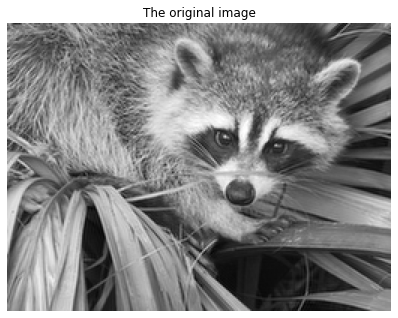

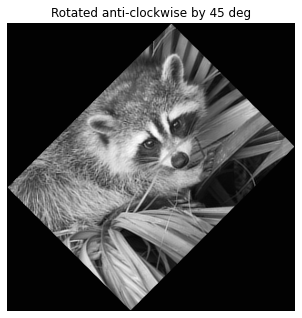

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage, misc, signal

U = misc.face(gray=True).astype(np.float32)

# Decimate it by a factor of 4 along both axes.
U = signal.decimate(signal.decimate(U, 4, axis = 0), 4, axis = 1)
V = ndimage.rotate(U, 45)

def show_bare_image(img, title):
  fig = plt.figure(frameon = False)
  ax = plt.Axes(fig, [0, 0, 1, 1])
  ax.set_axis_off()
  fig.add_axes(ax)

  plt.imshow(img)
  plt.gray()
  plt.title(title)
  plt.show()

show_bare_image(U, 'The original image')
show_bare_image(V, 'Rotated anti-clockwise by 45 deg')

## Estimation of probability density

Calculation of entropy and mutual information requires a knowledge of the probability density. We estimate it using a Gaussian window in the next code snippet.

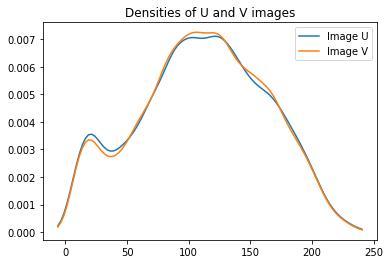

In [0]:
from scipy import stats

# Choose a random sample from U and V. It is 50% of the image data.
N_A = np.prod(U.shape) // 2

idx_U = np.random.choice(np.prod(U.shape), 
                       size = N_A)

U_A = U.reshape(np.prod(U.shape))[idx_U]

# We remove the black pixels added when we rotated the image.
V = np.ma.masked_equal(V, 0).compressed()
idx_V = np.random.choice(np.prod(V.shape), 
                       size = N_A)

V_A = V.reshape(np.prod(V.shape))[idx_V]

# Estimate the density.
kde_u = stats.gaussian_kde(U_A.reshape(np.prod(U_A.shape)))
kde_v  = stats.gaussian_kde(V_A.reshape(np.prod(V_A.shape)))

# Plot the two densities.
least = min(np.min(U_A), np.min(V_A))
most  = max(np.max(U_A), np.max(V_A))
x = np.linspace(least, most, num = 100)

plt.plot(x, kde_u(x), label = 'Image U')
plt.plot(x, kde_v(x), label = 'Image V')
plt.title('Densities of U and V images')
plt.legend()
plt.show()

## Estimation of entropy


In [0]:
# Choose another sample of the data.
# Choose a random sample from U and V. It is 1/3rd of the image data.
N_B = np.prod(U.shape) // 3

idx_U = np.random.choice(np.prod(U.shape), size = N_B)
U_B = U.reshape(np.prod(U.shape))[idx_U]

idx_V = np.random.choice(np.prod(V.shape), size = N_B)
V_B = V.reshape(np.prod(V.shape))[idx_V]

x_U = np.arange(np.min(U_B), np.max(U_B), N_B)
x_V = np.arange(np.min(V_B), np.max(V_B), N_B)

p_U = kde_u(x_U)
p_V = kde_v(x_V)

h_U = -np.log(p_U)/N_B
h_V = -np.log(p_V)/N_B

print(f'Entropy of image U is {h_U}.')
print(f'Entropy of image V is {h_V}.')


Entropy of image U is [0.0004433].
Entropy of image V is [0.00047443].


## Estimation of the derivative of mutual information
The expression for the derivative of mutual information $I$ with respect to a transformation $T$ is given by
$$
\begin{eqnarray}
\widehat{\frac{dI}{dT}} &=& \frac{1}{N_B}\sum_{v_i \in B}\sum_{v_j \in B}W_v(v_i, v_j)(v_i - v_j)^T\psi_v^{-1}\frac{d}{dT}(v_i - v_j) - \\
 & & 
\frac{1}{N_B}\sum_{w_i \in B}\sum_{w_j \in B}W_w(w_i, w_j)(w_i - w_j)^T\psi_w^{-1}\frac{d}{dT}(w_i - w_j).
\end{eqnarray}
$$

This is a complicated expression and we will explain how to compute every term in it. We start with the original image $u$ and a transformation $T$. Then

1. $u_i = u(x_i)$ is a pixel of the original image,
2. $v_i = v(T(x_i))$ is a pixel of the transformed image,
3. $w_i = (u_i, v_i)^T$,
4. $\psi_v^{-1}$ is the variance of $v(x_i)$,
5. $\psi_{vu}^{-1} = \text{diag}(\psi_v^{-1}, \psi_u^{-1})$ so that $\psi_{vv}^{-1} = \text{diag}(\psi_v^{-1}, \psi_v^{-1})$,
6. $G_\psi(z) = (2\pi)^{n/2}|\psi|^{-1/2}\exp(-z^T\psi^{-1} z/2)$ is the gaussian density at $z$ assuming a mean of zero and covariance matrix $\psi^{-1}$. Here $n$ is the dimension of the random vector $z$. If we are dealing with a simple gray scale image $n = 1$ and the matrix $\psi^{-1}$ is just a number.
7. The weighting factor $W_v(v_i, v_j)$ is defined as
$$
W_v(v_i, v_j) = \frac{G_{\psi_u}(v_i - v_j)}{\sum_{x_k \in A}G_{\psi_u}(v_i - v_k)}.
$$
Refer to item 2 for the definition of $v_i$.
8. The weighting factor $W_{uv}(w_i, w_j)$ is defined as
$$
W_{uv}(w_i, w_j) = \frac{G_{\psi_{uv}}(w_i - w_j)}{\sum_{x_k \in A}G_{\psi_{uv}}(w_i - w_k)}.
$$
9. The term with derivative of $(v_i - v_j)$ with respect to the transformation $T$ is given by
$$
\frac{d}{dT} \left(v(T(x_i)) - v(T(x_j))\right)= \nabla v(T(x_i))x_i^T - \nabla v(T(x_j))x_j^T.
$$
Refer to the last few lines in the section <a href="EMMA">EMMA</a> where we argue that this expression cannot be correct for two reasons, (a) the result of this operation is incompatible with the rest of the terms and (b) the transformation $T$ does not appear on the right hand side. (The superscript $^T$ on the right hand side stands for the transpose operation.)

Before implementing this algorithm, we will illustrate each step with a python code snippet.

### Step 1
Choose a pixel of the image. In order to do so, we reshape the image into a one-dimensional array.

In [0]:
# Read the image.
U = misc.face(gray=True).astype(np.float32)
# Decimate it by a factor of 3 along the X axis and 4 along the Y axis. That 
# gives us a small 256 x 256 image.
# to use small images for sake of illustration. 
U = signal.decimate(signal.decimate(U, 3, axis = 0), 4, axis = 1)
# Reshape it.
u = U.reshape(np.prod(U.shape))

### Step 2
Apply the transformation $T$ to the position $x_i$ of the pixels in the original image. Choose a pixel in the second image corresponding to the transformed value.

In [0]:
# Our target image is really the original image rotated.
V = ndimage.rotate(U, 45)
# We remove the black pixels added when we rotated the image.
V = np.ma.masked_equal(V, 0).compressed()
# Reshape it.
v = V.reshape(np.prod(V.shape))

# We next create a simple transformation. The simplest is the identity 
# transformation. T acts on x_i. There are 256 x 256 of them. Therefor
# it should be a much larger matrix.
T = np.identity(np.prod(U.shape))

# x is the matrix of all positions, it is [0, 1, ..., 256**2 - 1]
x = np.linspace(0, np.prod(U.shape) - 1, np.prod(U.shape))
# Let us call T(x) = y. Thus,
y = np.matmul(T, x)


### Step 3
Build the vector $w$.

In [0]:
w = np.matrix([x, y])

### Steps 4, 5 and 6
Get the variance of $v$. Use it to build the vector $\psi_{vv}^{-1}$. 

In [0]:
psi_inv_v = np.var(v)
psi_inv_vv = np.diag([psi_inv_v, psi_inv_v])

### Step 7
Build the weighting factor $W_v(v_i, v_j)$.

In [0]:
# A function that implements the gaussian kernel for u.
def gk_1d(z, psi_inv):
  # n and d stand for the numerator and the denominator.
  n = math.exp(-z**2/(2 * psi_inv)) # Recall that the mean is assumed to be zero.
  d = math.sqrt(2 * math.pi * psi_inv)

  return n/d

# W_v(v_i, v_j) is an n x n matrix, where n is the length of the vector v. It
# is also a symmetric matrix. However, to keep the code simple, we will not 
# exploit the symmetry but will compute all its elements separately.
n = len(v)
W = np.zeros(shape = (n, n))
# Note that the first argument of W_v comes from the sample B and the second
# one from the sample A. We differentiate the two elements with the symbols vb
# and va.
for i in range(n):
  for j in range(n):
    W[i, j] = get_1d(vb[i] - va[j], psi_inv_v)

# So far we have computer only the numerator of the expression in 7. The 
# denominator is just the sum of all elements of W.
W = W/W.sum()


### Step 8
Build the weighting factor $W_{uv}(w_i, w_j)$.

In [0]:
# A function that implements the gaussian kernel for w = [u, v]
def get_2d(w, psi_inv):
  # n and d stand for the numerator and the denominator.
  n = np.exp(-0.5 * np.dot(np.matmul(w, psi_inv), w))
  # The covariance matrix is diagonal. Therefore, its determinant is just the
  # product of its diagonal elements.
  det_psi = np.prod(np.diag(psi_inv))
  d = 2 * math.pi * math.sqrt(det_psi)

  return n/d

n = len(v)
W1 = np.zeros(shape = (n, n))
for i in range(n):
  for j in range(n):
    W1[i, j] = get_2d(w[:, i] - w[:, j], psi_inv_vv)

# So far we have computer only the numerator of the expression in 7. The 
# denominator is just the sum of all elements of W.
W1 = W1/W1.sum()



### Step 9
Finding the derivative of $v$ with respect to the transformation $T$. <font color="red">At this point in time, we do not know how to implement this term. Refer to remark under point 9 in the section <a href="Estimation of the derivative of mutual information">Estimation of the derivative of mutual information</a>.</font>
